# Introduction

I have a dataset of about 20,000 Airbnb listings in Amsterdam, The Netherlands scraped from the Airbnb website by [Inside Airbnb](http://insideairbnb.com/get-the-data.html). This notebook performs an exploratory analysis on the dataset to predict the price. The rest of the notebook proceeds as follows:

1. data cleaning, which involves data type conversion, column reformatting, and dropping collinear columns;
2. preliminary analysis by visualizing distribution and correlation of predictors;
3. grid search the best preprocessing parameters and regression model.

### What to expect in this project

- Visualization: histogram, heatmap, lollipop plot, boxplot
- Machine Learning: principal component analysis, scaling, regression, grid search 

In [58]:
# import favorite packages
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})
import seaborn as sns
import re

# global option settings
pd.set_option('display.max_columns', None) # show all column names display
pd.set_option('display.max_rows', None) # show all rows on display

In [59]:
df = pd.read_csv('listings.csv', index_col = "id", low_memory = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20677 entries, 2818 to 37590988
Columns: 105 entries, listing_url to reviews_per_month
dtypes: float64(23), int64(20), object(62)
memory usage: 16.7+ MB


In [60]:
print('{} rows, {} attributes'.format(df.shape[0], df.shape[1]))
print('Scraped on {}'.format(set(df.last_scraped)))

20677 rows, 105 attributes
Scraped on {'2019-08-08', '2019-09-03', '2019-08-09'}


# Cleaning data

### Expand `amenities`  and `host_verifications` to dummy variables

Since the entries of `amenties` and `host_verifications` columns are lists of strings, I will be expanding them into 123 columns and 21 columns of dummy variables respectively. 

In [61]:
print(df[['amenities', 'host_verifications']][:2])

                                               amenities  \
id                                                         
2818   {Internet,Wifi,"Paid parking off premises","Bu...   
20168  {TV,Internet,Wifi,"Paid parking off premises",...   

                                      host_verifications  
id                                                        
2818   ['email', 'phone', 'reviews', 'jumio', 'offlin...  
20168  ['email', 'phone', 'reviews', 'jumio', 'offlin...  


In [62]:
import itertools

def amenity_df(df):
    """
    Expand the amenities columns into a dataframe of dummy variables
    """
    rows = [
                    [a.strip('""') for a in amenities.strip("{}").split(",") \
                    if "translation missing" not in a and a != '' and a != 'None'] \
                        for amenities in df['amenities']
                    ]
    amenities = set(list(itertools.chain.from_iterable(rows)))
    dict_rows = []
    for row in rows:
        amenity_dictionary = dict.fromkeys(amenities, 0)
        for r in row:
            amenity_dictionary[r] = 1
        dict_rows.append(amenity_dictionary)
    return pd.DataFrame.from_dict(dict(zip(df.index, dict_rows)), orient = 'index', dtype = 'bool')

a = amenity_df(df)
df = df.join(a)
df.drop('amenities', axis = 1, inplace = True)
print('Number of amenity columns: {}'.format(a.shape[1]))
print('Amenity names: \n{}'.format(a.columns))

Number of amenity columns: 123
Amenity names: 
Index(['Breakfast', 'Hot water', 'Table corner guards', 'Wide hallways',
       'Cleaning before checkout', 'Room-darkening shades',
       'Wide doorway to guest bathroom', 'Stove', 'Keypad',
       'Babysitter recommendations',
       ...
       'Pets allowed', 'Heating', 'Fixed grab bars for shower',
       'Self check-in', 'Roll-in shower', 'Essentials', 'Air purifier',
       'Patio or balcony', 'Shampoo', 'Paid parking on premises'],
      dtype='object', length=123)


In [63]:
def host_verifications_df(df):
    """
    Expand host_verification column into a dataframe of dummy variables
    """
    rows = [ 
                [r.strip("''") for r in row.strip('[]').split(', ') \
                if r != '' and r != 'None']
            for row in df['host_verifications']
    ]
    methods = set(list(itertools.chain.from_iterable(rows)))
    dict_rows = []
    for row in rows:
        verify_dictionary = dict.fromkeys(methods, 0)
        for r in row:
            verify_dictionary[r] = 1
        dict_rows.append(verify_dictionary)
    return pd.DataFrame.from_dict(dict(zip(df.index, dict_rows)), orient = 'index', dtype = 'bool')

host_v = host_verifications_df(df)
df.drop('host_verifications', axis = 1, inplace = True)
df = df.join(host_v)
print('Number of host verification columns: {}'.format(host_v.shape[1]))
print('Verification methods: \n{}'.format(host_v.columns))

Number of host verification columns: 19
Verification methods: 
Index(['google', 'facebook', 'sesame_offline', 'jumio', 'manual_offline',
       'weibo', 'work_email', 'reviews', 'offline_government_id',
       'zhima_selfie', 'identity_manual', 'manual_online', 'phone',
       'government_id', 'selfie', 'kba', 'sent_id', 'email', 'sesame'],
      dtype='object')


## Convert data types

Inspecting the data types, I see that a number of variables do not have the appropriate data type. Here are the data type conversions I will be making to the data:

- from `object` to `float64` or `int64` (e.g. `price`);
- from `int64` to `object` (e.g. id) because the number itself has no meaning;
- from `object` to `bool` (e.g. `is_business_travel_ready`);
- from `object` to `date64` (e.g. `last_review`).

In [64]:
def convert_price(val):
    """
    Converts price values that are currently string to float data types 
    by stripping dollar symbols and commas
    if either exists in the string. Returns a float.
    ----
    val (str)
    newval (float)
    """
    dollar_sign = re.compile('$')
    comma_sign = re.compile(',')
    val = str(val) # make sure they are string at this point
    
    if dollar_sign.search(val) == None:
        if comma_sign.search(val) != None:
            newval = val.replace(',', '')
        else:
            newval = val
    else:
        if comma_sign.search(val) == None:
            newval = val.replace('$', '')
        else:
            newval = val.replace('$', '').replace(',', '')
    return float(newval)

def convert_to_numeric(df):
    """
    Convert columns containing percentages and 
    currency values from object to numeric. 
    Returns a new dataframe.
    """
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype('float') 
    currency_col = list(filter(lambda x: x.endswith('price'), list(df))) + \
                    ['security_deposit', 'cleaning_fee', 'extra_people', 'price']
    for col in currency_col:
        df[col] = df[col].apply(convert_price)
    
    return df

df = convert_to_numeric(df)

In [65]:
from datetime import date 

def process_datetime(df):
    """
    Convert columns containing dates from object to datetime64 and then 
    calculate and add the following features:
        - the number of days the host has been serving as a host on Airbnb ('host_since_days'),
        - the number of days since the first review ('first_reviewed')
        - the number of days since the last review ('last_reviewed').
    Returns the new dataframe with all the datetime columns dropped. 
    """

    dates = ['last_scraped', 'host_since', 'calendar_last_scraped', 
             'first_review', 'last_review']
    for col in dates:
        df[col] = pd.to_datetime(df.loc[:, col], format = '%Y-%m-%d')
    df['host_since_days'] = (df.last_scraped - df.host_since).dt.days
    df['first_reviewed'] = (df.last_scraped - df.first_review).dt.days
    df['last_reviewed'] = (df.last_scraped - df.last_review).dt.days
    
    return df.select_dtypes(exclude = 'datetime')

df = process_datetime(df)

In [66]:
def convert_to_boolean(df):
    """
    Convert columns that have only 2 unique values to boolean.
    """
    # select columns that have only 2 unique values
    dummies = list(col for col in df.columns if df.loc[:, col].nunique() == 2)  
    for col in dummies:
        df.loc[:, col] = df.loc[:, col].map({'t': True, 'f': False}).astype('bool')
    return df

df = convert_to_boolean(df)

## Convert to category

Many of the string variables can be converted appropriately into categorical data type. The table shows the number of unique values and the proportion of NaN values for each string column.

In [40]:
# Count how many unique values each column has 
unique_counts = pd.DataFrame.from_records(
            [(col, df[col].nunique(), sum(df[col].isna())/len(df[col])) for col in df.columns
                                          if df[col].dtype != 'bool' and df[col].dtype != 'int' 
                                           and df[col].dtype != 'float'],
                          columns=['Column_Name', 'Num_Unique', 'Num_NaN']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique,Num_NaN
39,is_business_travel_ready,1,0.000000
36,requires_license,1,0.000000
35,has_availability,1,0.000000
5,experiences_offered,1,0.000000
29,country_code,1,0.000000
30,country,1,0.000000
32,room_type,3,0.000000
38,jurisdiction_names,4,0.001789
17,host_response_time,4,0.413068
27,market,4,0.001935


Columns with only 1 unique value (e.g. `country`) are not informative, so it's best to drop them. At the other extreme end, there are features with 20,000+ unique values such as `description`. It's not informative to treat these as categorical either, so we need to choose cutoff points. Note that there is a huge jump from `host_location`, which has 581 unique values, to `host_name`, which has 6,000+ unique values. I will treat variables between 3 and 600 unique values as categorical. 

In [67]:
def convert_categorical(df):
    """
    Convert the following columns from object to categorical. We set a rule
    to only convert if the number of categories between 600 and 3.
    """
    categorical_var = [col for col in df.columns if df[col].dtype == 'object' and \
                       df[col].nunique() >= 3 and df[col].nunique() <= 600] 
    for var in categorical_var:
            df[var] = df[var].astype('category')
    return df

df = convert_categorical(df)

## Drop uninformative and redundant features

The original dataframe has 105 features. There are three types of columns that can be dropped from the data matrix:

- columns with one unique value (e.g. `is_business_travel_friendly`);
- columns whose names end with 'id' or 'url';
- and collinear columns. 

There are several columns that, though they are not identical, still have strong correlation. Multicollinearity would distort coefficient estimates and their variance, so I will drop collinear columns. For example, `minimum_nights`, `minimum_minimum_nights`, `maximum_minimum_nights`, and  `minimum_nights_avg_ntm` have strong correlations with each other, so there won't be any information lost from dropping the last three and only keeping the first.

In [68]:
df[['minimum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_nights_avg_ntm']].corr(method = 'pearson')

,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_nights_avg_ntm
minimum_nights,1.000000,0.998611,0.988985,0.995656
minimum_minimum_nights,0.998611,1.000000,0.989012,0.995752
maximum_minimum_nights,0.988985,0.989012,1.000000,0.995716
minimum_nights_avg_ntm,0.995656,0.995752,0.995716,1.000000


In [69]:
df[['maximum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm']].corr(method = 'pearson')

,maximum_nights,minimum_maximum_nights,maximum_maximum_nights,maximum_nights_avg_ntm
maximum_nights,1.000000,0.972621,0.988657,0.983126
minimum_maximum_nights,0.972621,1.000000,0.985698,0.996169
maximum_maximum_nights,0.988657,0.985698,1.000000,0.994980
maximum_nights_avg_ntm,0.983126,0.996169,0.994980,1.000000


In [70]:
df[['number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month']].corr(method = 'pearson')

,number_of_reviews,number_of_reviews_ltm,reviews_per_month
number_of_reviews,1.000000,0.791161,0.659671
number_of_reviews_ltm,0.791161,1.000000,0.831045
reviews_per_month,0.659671,0.831045,1.000000


There are multiple categories for which the guests can give [ratings](https://www.airbnb.com/help/article/1257/how-do-star-ratings-work-for-stays). According to the correlation heatmap, most categories have high correlation with each other except for `review_scores_location`, which has approximately 0.3 correlation score with other rating categories including the overall rating. This makes sense because if there are multiple categories in which a guest can rate her stay, even if she were happy overall, she would feel more open to be honest about the cons. I will be keeping `review_scores_rating` and `review_scores_location` but drop rest of the categories to avoid multicollinearity.

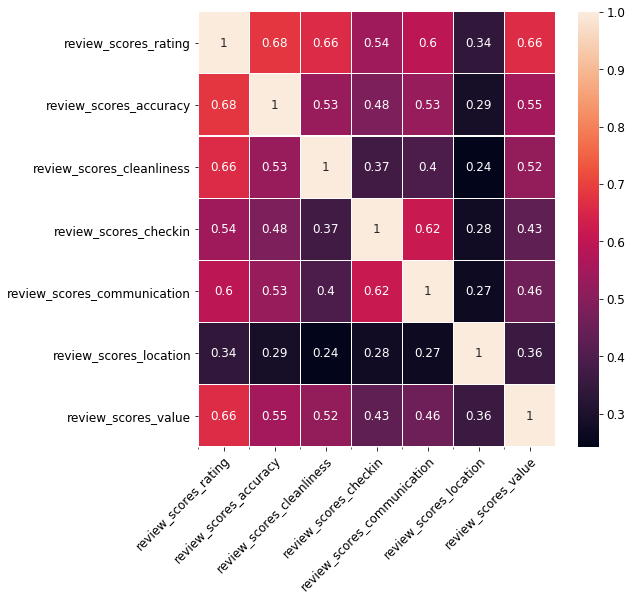

In [71]:
fig, ax = plt.subplots(figsize=(8, 8))
scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', \
    'review_scores_value']
ax = sns.heatmap(df[scores].corr(method = 'pearson'), annot = True, linewidth = 0.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticks(range(len(scores)), scores)
ax.set_xticklabels(scores, rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.show()

In [73]:
df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].corr()

,availability_30,availability_60,availability_90,availability_365
availability_30,1.000000,0.940456,0.880449,0.572649
availability_60,0.940456,1.000000,0.971084,0.648979
availability_90,0.880449,0.971084,1.000000,0.705384
availability_365,0.572649,0.648979,0.705384,1.000000


There are several features whose name suggests that they count how many Airbnb listings a host has. There is no documentation for what each feature is counting precisely or how `calculated_host_listings_count` differ from `host_listings_count` and `host_total_listings_count`. Since there are some 1.0 correlations and high correlations off the diagonal, I will be only be keeping `host_listings_count`. 

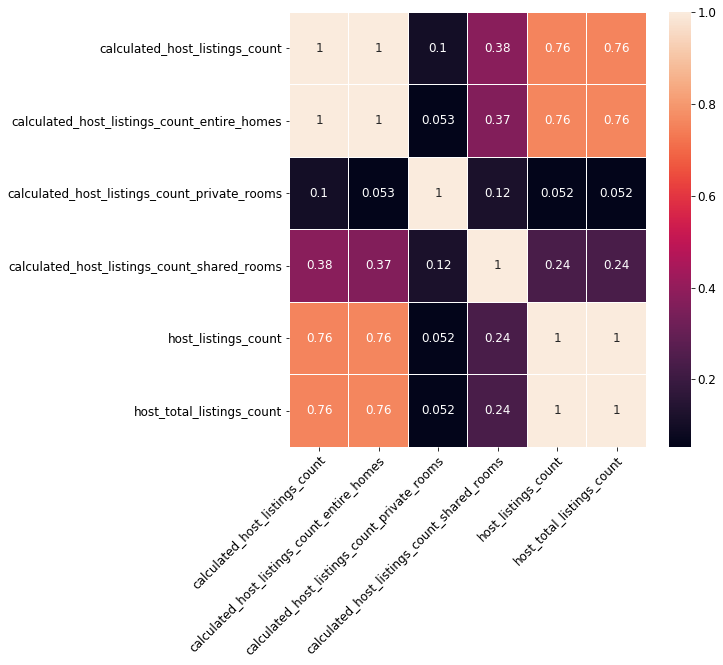

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))
host_listings = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
   'host_listings_count', 'host_total_listings_count']
ax = sns.heatmap(df[host_listings].corr(), annot = True, linewidth = 0.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(host_listings, rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.show()

I check the correlation of host verification methods to see whether any of the columns can be dropped. The heatmap shows that `sesame` and `sesame_offline` have 1.0 correlation, so the two methods are redundant. `manual_online` and `manual_offline`, and `jumio`, `identity_manual`, `offline_government_id`, `selfie`, and `government_id` have very strong correlation. I will drop `sesame_offline`, `manual_offline`, `jumio`, `identity_manual`, `selfie`, `offline_government_id`. 

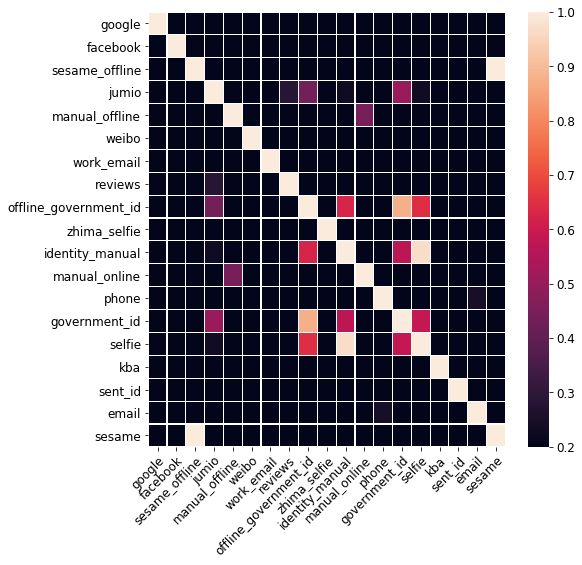

In [75]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(host_v.corr(), linewidth = 0.1, vmin = 0.2)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(host_v.columns, rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.show()

In [76]:
def drop_collinear(df):
    """
    Drop collinear columns.
    """
    collinear = ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_nights_avg_ntm'] + \
                ['minimum_maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm'] + \
                [ 'review_scores_accuracy', 'review_scores_cleanliness',
                'review_scores_checkin', 'review_scores_communication', 'review_scores_value'] + \
                [ 'availability_60', 'availability_90', 'availability_365'] + \
                ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
             'calculated_host_listings_count_private_rooms', 
            'calculated_host_listings_count_shared_rooms', 'host_total_listings_count'] + \
            ['number_of_reviews_ltm', 'reviews_per_month'] + \
            ['sesame_offline', 'manual_offline', 'jumio', 'identity_manual', 'selfie', 'offline_government_id']
    for col in collinear:
        df.drop(col, axis = 1, inplace = True)
    return df

df = drop_collinear(df)

In [77]:
def drop_uninformative(df):
    """
    Drop columns that have only one unique value,
    columns whose name ends with 'id' or 'url', 
    and other columns that I deemed uninformative or redundant.
    
    """
    not_informative = [col for col in df.columns if
                      col.endswith('url') or col.endswith('id')] + \
                    [col for col in df.columns if 
                    df[col].nunique() < 2] + \
                    ['weekly_price', 'monthly_price'] + \
                    ['host_neighbourhood', 'neighbourhood', 'jurisdiction_names', \
                     'host_location', 'smart_location', 'market', 'zipcode'] + \
                    ['calendar_updated'] + \
                    ['license'] # too many NaN values 
        
    for col in list(set(not_informative)): # make sure that there is no duplicate columns
        df.drop(col, axis = 1, inplace = True)
        
    return df

df = drop_uninformative(df)

## Other text data

We have a number of features whose entries are strings of text, but not every Airbnb host filled out all entries. In fact, only the `host_name`, `name`, `description`, and `summary` have less than 5% incompletion rate. 

In [78]:
text_columns = df.select_dtypes(include = 'object').columns
pd.DataFrame.from_records(
    [(col, df[col].isna().sum()/len(df[col])) for col in text_columns],
    columns=['Column_Name', 'Num_NaN']).sort_values(by=['Num_NaN'])

,Column_Name,Num_NaN
10,host_name,0.000580
0,name,0.001693
3,description,0.010591
1,summary,0.030420
2,space,0.262224
6,transit,0.304783
4,neighborhood_overview,0.318421
9,house_rules,0.381245
8,interaction,0.386323
7,access,0.409537


Processing and modeling the text data will take some time. Instead, for now I will create dummy variables indicating whether the field was filled out by the Airbnb host. 

In [79]:
def blank_text(df):
    """
    Takes a string-type column other than `amenities` and recodes variable to whether the 
    text filed was left blank or not. Yes == 1, No == 0.
    """
    text_columns = df.select_dtypes(include = 'object').columns
    for col in text_columns:
        df[col + '_blank'] = df[col].isna()
        df.drop(col, axis = 1, inplace = True)
    return df

df = blank_text(df)

# Preliminary analysis

## Price per night 

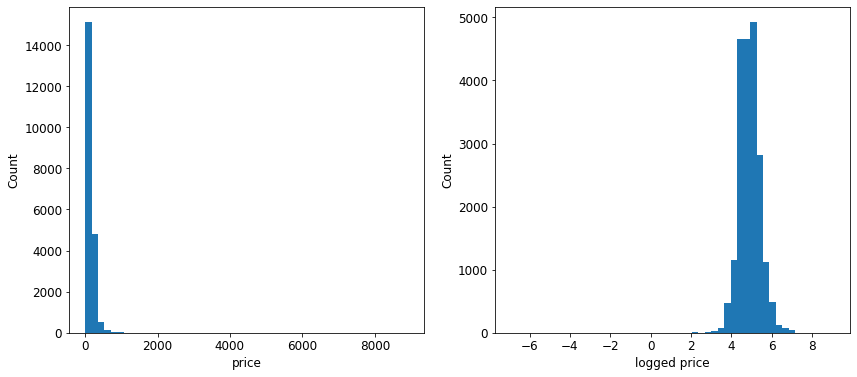

In [80]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))
axes[0].hist(df['price'], bins = 50)
axes[0].set_ylabel('Count')
axes[0].set_xlabel('price');

df['log_price'] = np.log(df['price'] + 0.001) # add 0.001 to avoid Inf
axes[1].hist(df['log_price'], bins = 50) 
axes[1].set_ylabel('Count')
axes[1].set_xlabel('logged price')
plt.show()

The pair of histograms above suggest that we log-transform `price` to have a more normally distributed target variable. There seems to be some outliers at both extreme ends of the price spectrum. The histogram on the left suggests that there are listings that charge over 8000 dollars per night. The histogram of the logged price on the right, however, also indicates that there may be listings that charge 0 dollars per night. 

In [81]:
print("Top 10 most expensive prices:\n{}".format(df[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].sort_values(by = 'price', ascending = False)[:10]))

Top 10 most expensive prices:
           price  security_deposit  cleaning_fee  extra_people
id                                                            
6655554   8915.0               0.0         500.0           0.0
258273    8000.0              80.0          15.0          15.0
33842636  7550.0               0.0           0.0          80.0
29828125  6500.0               NaN           NaN           0.0
29926643  5040.0             100.0          50.0          70.0
19686192  5000.0               NaN           NaN           0.0
5341871   4500.0             500.0           0.0         250.0
15626614  3142.0               NaN           NaN           0.0
28651212  3000.0             200.0           0.0          25.0
11040717  2500.0               NaN          40.0           0.0


In [82]:
print("Top 10 cheapest prices:\n{}".format(df[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].sort_values(by = 'price', ascending = True)[:10]))

Top 10 cheapest prices:
          price  security_deposit  cleaning_fee  extra_people
id                                                           
20597844    0.0            1000.0          45.0           0.0
33415416    9.0               0.0          25.0          15.0
28936641    9.0               NaN           NaN           0.0
6764212     9.0               0.0           0.0           0.0
36034838    9.0               NaN           NaN           0.0
32463748   10.0               NaN           NaN           0.0
4009850    12.0               NaN           NaN           0.0
6352873    14.0             200.0           0.0           0.0
36221425   15.0               NaN           NaN           0.0
11147683   19.0               NaN           NaN           0.0


The listing that charges 0 dollars per night actually charges 1000 dollars for security deposity. Upon closer inspection, it turns out that this listing actually lends an entire apartment, so it is misleading to regard this listing as the cheapeast Airbnb in Amsterdam. 

To fix this sort of deception, I am going to reformulate price per night as the sum of `price` and `security_deposit`. The new variable is called `price_total` and log this for `log_price`. 

In [83]:
def define_price(df):
    """
    Redefine price per night as the sum of `price`, `security_deposit`, `cleaning_fee`, and `extra_people`. 
    Drop these columns and call the sum `price_total`.
    """
    for col in ['price', 'security_deposit', 'cleaning_fee', 'extra_people']:
        df[col] = df[col].fillna(0.0)
    df['price_total'] = df['price'] + df['security_deposit'] + df['cleaning_fee'] + df['extra_people']
    df.drop(['price', 'security_deposit', 'cleaning_fee', 'extra_people'], axis = 1, inplace = True)
    return df

df = define_price(df)
df['log_price'] = np.log(df['price_total'])

/Users/asako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


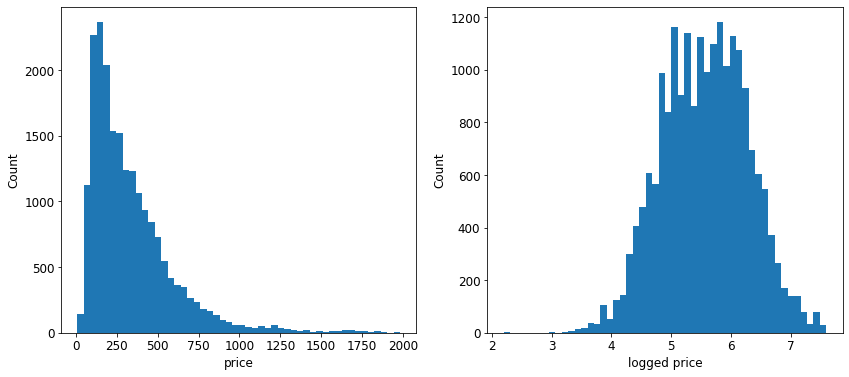

In [252]:
df_rmoutliers = df.loc[df.price_total <= 2000, :]
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))
axes[0].hist(df_rmoutliers['price_total'], bins = 50)
axes[0].set_ylabel('Count')
axes[0].set_xlabel('price');

df_rmoutliers['log_price'] = np.log(df_rmoutliers['price_total'] + 0.001) # add 0.001 to avoid Inf
axes[1].hist(df_rmoutliers['log_price'], bins = 50) 
axes[1].set_ylabel('Count')
axes[1].set_xlabel('logged price')
plt.show()

In [253]:
def rm_outliers(df):
    """
    Remove observations with 'price_total' greater than 2000.
    """
    return df.loc[df.price_total <= 2000]

## Room and bed types

The next set of columnss--`room_type` and `bed_type`--are important informations for travellers when they look up Airbnb listings. 

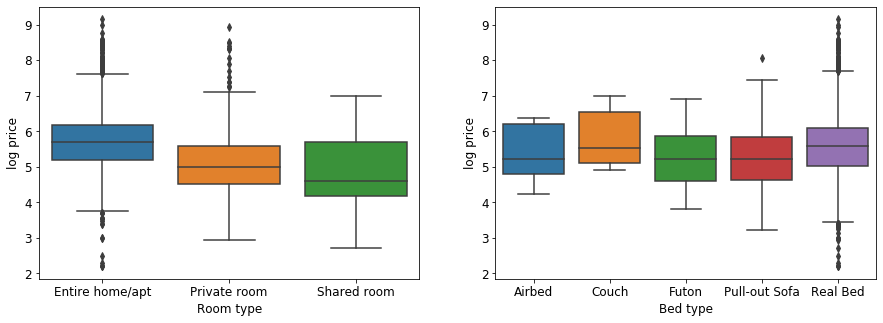

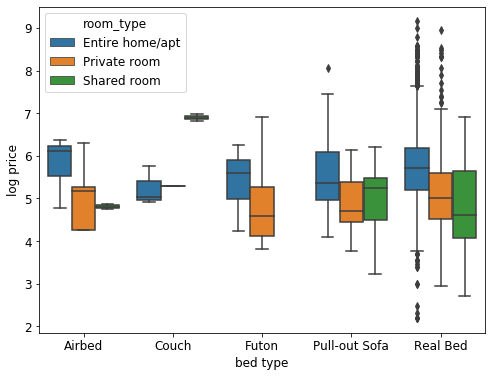

In [84]:
fig, axes = plt.subplots(1, 2,  figsize = (15, 5))
axes = axes.flatten()

sns.boxplot('room_type', 'log_price', data = df, ax = axes[0])
axes[0].set_xlabel('Room type')
axes[0].set_ylabel('log price')
sns.boxplot('bed_type', 'log_price', data = df, ax = axes[1])
axes[1].set_xlabel('Bed type')
axes[1].set_ylabel('log price')
plt.show()

plt.figure(figsize = (8, 6))
sns.boxplot('bed_type', 'log_price', data = df, hue = 'room_type')
plt.xlabel('bed type')
plt.ylabel('log price')
plt.show()

I expected that room type would show a clear relationship with price, i.e. the more space available to the guest, the higher the price. The lack of clear relationship between bed type and price was unexpected, but this seems reasonable because even if a real bed is provided, the guest could be given access either only to a single room or the whole house/apartment. Consequently, when I separate the bed types by room types, it shows that for each bed type, the price generally falls the more space the guest has to herself. The only combination that deviates from the trend is combination `couch` x `Shared room`.

##  `accommodates`, `bathrooms`, `bedrooms`, `beds`, `square_feet`

In general, more space as measured by accomodation size, number of bathrooms, bedrooms, beds, and square feet, the more expensive the price. 

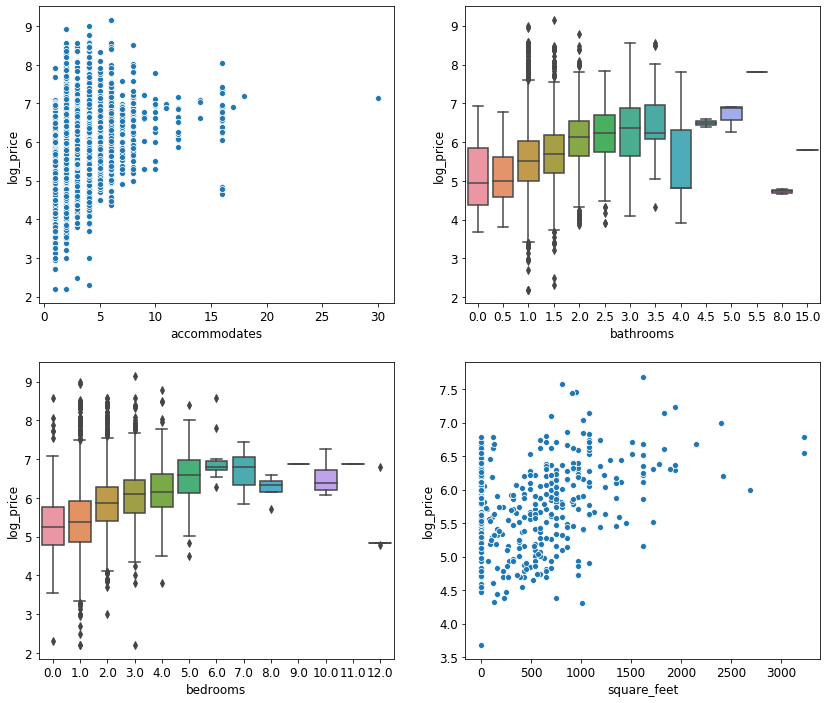

In [85]:
fig, axes = plt.subplots(2, 2,  figsize = (14, 12))
axes = axes.flatten()

sns.scatterplot('accommodates', 'log_price', data = df, ax = axes[0])
sns.boxplot('bathrooms', 'log_price', data = df, ax = axes[1])
sns.boxplot('bedrooms', 'log_price', data = df, ax = axes[2])
sns.scatterplot('square_feet', 'log_price', data = df, ax = axes[3])

plt.show()

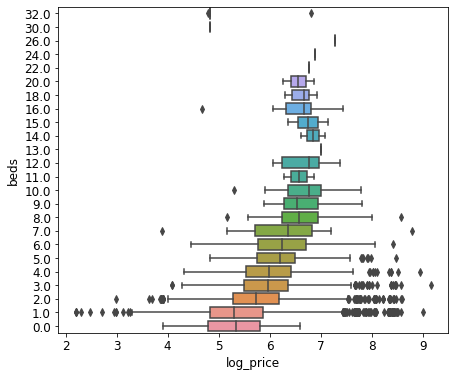

In [86]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x='log_price', y='beds', data=df, orient='h', ax = ax)
ax.invert_yaxis()
plt.show()

## `host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`

There seems to be no difference in price from whether the host is a super host, has a profile picture, or has verified identity. 

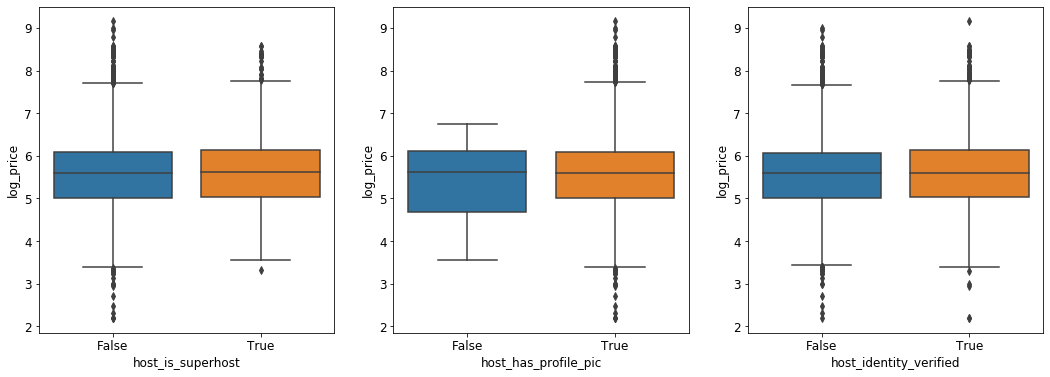

In [87]:
fig, axes = plt.subplots(1, 3,  figsize = (18, 6))
axes = axes.flatten()

sns.boxplot('host_is_superhost', 'log_price', data = df, ax = axes[0])
sns.boxplot('host_has_profile_pic', 'log_price', data = df, ax = axes[1])
sns.boxplot('host_identity_verified', 'log_price', data = df, ax = axes[2])


plt.show()

## `availability_30`, `instant_bookable`, `require_guest_profile_picture`, `require_guest_phone_verification`

Some listings are probably more convenient for guests to book because it has a lot of availability, is instantly bookable, or has lower verification requirement for the guest. On the other hand, I would guess pricier listings to require more planning for the guest to book. Although there is no discernable relationship between price and availability rate, listings that are instantly bookable, does not require guest profile picture, or does not require phone verification are cheaper. 

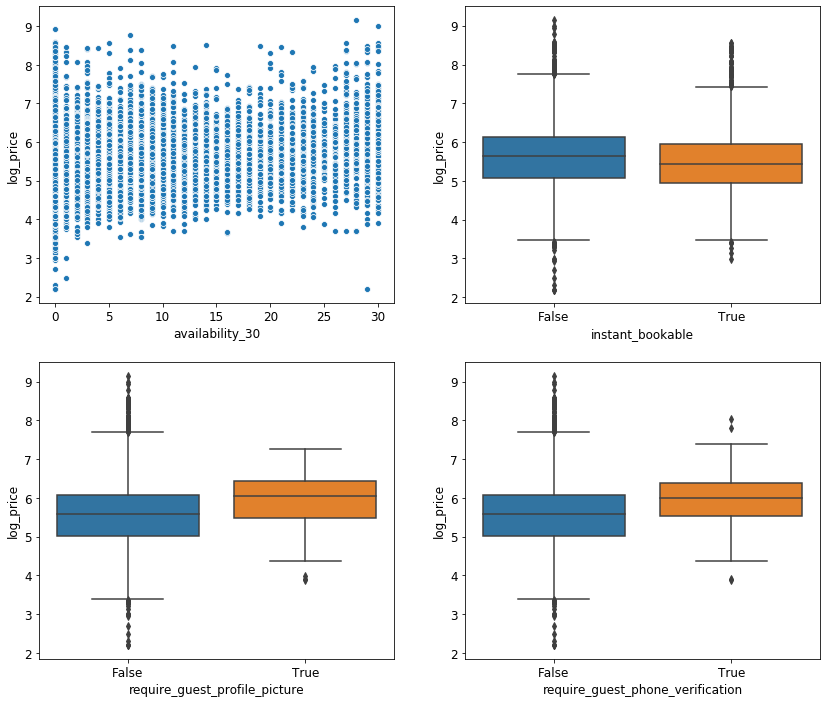

In [88]:
fig, axes = plt.subplots(2, 2,  figsize = (14, 12))
axes = axes.flatten()

sns.scatterplot('availability_30', 'log_price', data = df, ax = axes[0])
sns.boxplot('instant_bookable', 'log_price', data = df, ax = axes[1])
sns.boxplot('require_guest_profile_picture', 'log_price', data = df, ax = axes[2])
sns.boxplot('require_guest_phone_verification', 'log_price', data = df, ax = axes[3])

plt.show()

## Amenities 

I wanted to know whether certain amenities were more likely to come with listings of higher price. I plotted the difference in mean listing price between properties that did provide a given amenity and that did not. On the same plot, I also plotted the proportion of listings that did provided the amenity. 

In [90]:
amenities = a.join(df['price_total'])
amenity_prices = {}
for amenity in a.columns:
    price_dict = {}
    price_dict['median_T'] = np.median(amenities.loc[amenities[amenity] == True,'price_total'])
    price_dict['median_F'] = np.median(amenities.loc[amenities[amenity] == False,'price_total'])
    price_dict['max_T'] = np.max(amenities.loc[amenities[amenity] == True, 'price_total'])
    price_dict['max_F'] = np.max(amenities.loc[amenities[amenity] == False, 'price_total'])
    price_dict['min_T'] = np.min(amenities.loc[amenities[amenity] == True, 'price_total'])
    price_dict['min_F'] = np.min(amenities.loc[amenities[amenity] == True, 'price_total'])
    price_dict['mean_T'] = np.mean(amenities.loc[amenities[amenity] == True,'price_total'])
    price_dict['mean_F'] = np.mean(amenities.loc[amenities[amenity] == False,'price_total'])
    price_dict['prop'] = len(amenities.loc[amenities[amenity] == True])/amenities.shape[0]
    amenity_prices[amenity] = price_dict
A = pd.DataFrame.from_dict(amenity_prices, orient = 'index').sort_values(by = 'mean_T')

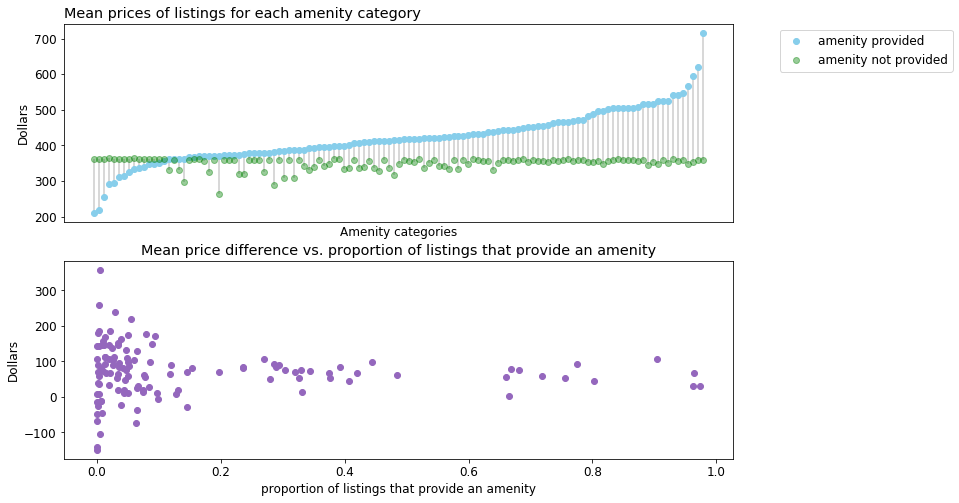

In [112]:
# Reorder it following the values of the first value:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes = axes.flatten()
my_range = range(1, len(A.index) + 1)
axes[0].plot(my_range, A['mean_T'], 'o', color='skyblue', alpha=1, label='amenity provided')
axes[0].plot(my_range, A['mean_F'], 'o', color='green', alpha=0.4 , label='amenity not provided')
axes[0].set_xticks([])
axes[0].set_title("Mean prices of listings for each amenity category", loc = 'left')
axes[0].set_ylabel('Dollars')
axes[0].set_xlabel('Amenity categories')
axes[0].legend(bbox_to_anchor=(1.06,1), loc = "upper left")
# draw vertical lines 
for i, cat in enumerate(A.index):
    ymin = min(A.loc[cat, 'mean_T'], A.loc[cat, 'mean_F'])
    ymax = max(A.loc[cat, 'mean_T'], A.loc[cat, 'mean_F'])
    axes[0].vlines(x = my_range[i], ymin = ymin, ymax = ymax, color = 'grey', alpha = 0.4)
    
color1 = 'tab:purple'
mean_diff = A['mean_T'] - A['mean_F']
axes[1].scatter(A['prop'], mean_diff, color = color1)
axes[1].set_ylabel('Dollars')
axes[1].set_xlabel('proportion of listings that provide an amenity')
axes[1].set_title('Mean price difference vs. proportion of listings that provide an amenity')

plt.show()

The plot above shows that amenities that have the greatest difference in mean listing price tend to be rare while common amenities can have a wide range of mean price difference. 

Amenities associated with the largest difference in mean price are related to safety features such as fireplace guards and child-friendly features such as babysitter recommendations, which only 3 % of the listings provide. 

In [113]:
A.sort_values(by = 'mean_T', ascending = False)[:10]

,median_T,median_F,max_T,max_F,min_T,min_F,mean_T,mean_F,prop
Fireplace guards,525.0,270.0,5239.0,9415.0,110.0,110.0,715.849462,359.136514,0.004498
Table corner guards,445.0,270.0,2075.0,9415.0,85.0,85.0,619.561644,359.823918,0.003530
Babysitter recommendations,475.0,265.0,5239.0,9415.0,73.0,73.0,593.615905,353.888928,0.028582
Indoor fireplace,435.0,260.0,9415.0,8110.0,20.0,20.0,566.982206,348.885184,0.054360
Pool,375.0,270.0,3050.0,9415.0,49.0,49.0,546.367089,360.028983,0.003821
Stair gates,449.5,265.0,4948.0,9415.0,84.0,84.0,542.738208,356.930776,0.020506
Firm mattress,525.0,270.0,1470.0,9415.0,110.0,110.0,540.769231,360.514261,0.001257
Children’s dinnerware,422.0,261.0,5239.0,9415.0,62.0,62.0,525.754826,352.036963,0.050104
Baby monitor,420.0,268.0,2450.0,9415.0,80.0,80.0,525.436620,358.447310,0.013735
High chair,415.0,258.0,5239.0,9415.0,74.0,74.0,524.352147,346.739434,0.078832


## Text fields on the listing page

Earlier, I have created columns that indicate whether a text field on the listing page was left blank or not. I noted that though almost every listing wrote something in the `name` section, about half of the listings left the `notes` section blank. I was curious whether there was a difference in price between listings that filled out a text field and those that did not. The plot shows that the largest mean diference in listing price is observed for text fields that had the smallest proportion of NaN's. This makes sense: hosts are unlikely to fill out text fields like `notes` and `access` unless they find them necessary whereas listings that leave the `name` field blank are distinctly different from listings that has the `name` field filled out. 

In [115]:
text_fields = [col for col in df.columns if col.endswith('_blank')]
text_summary = {}
for field in text_fields:
    stats = {}
    stats['prop_NaN'] = df.groupby(field).size()[0]/df.shape[0]
    stats['median_T'] = np.median(df.loc[df[field] == True,'price_total']) 
    stats['median_F'] = np.median(df.loc[df[field] == False, 'price_total'])
    stats['mean_T'] = np.mean(df.loc[df[field] == True,'price_total']) 
    stats['mean_F'] = np.mean(df.loc[df[field] == False, 'price_total'])
    stats['mean_diff'] = stats['mean_F'] - stats['mean_T']
    text_summary[field] = stats
T = pd.DataFrame.from_dict(text_summary, orient = 'index').sort_values(by = 'prop_NaN', ascending = False)

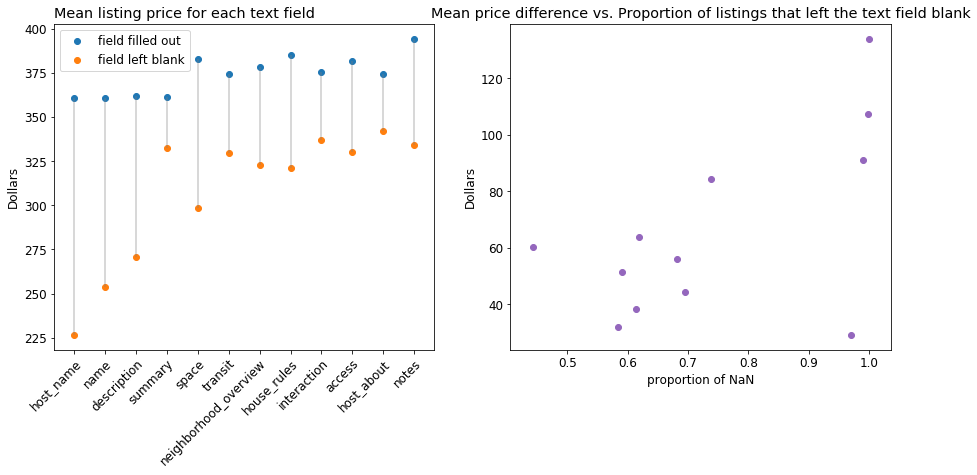

In [120]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes = axes.flatten()
my_range = range(1, len(T.index) + 1)
axes[0].scatter(my_range, T['mean_F'], label = 'field filled out')
axes[0].scatter(my_range, T['mean_T'], label = 'field left blank')
axes[0].set_title("Mean listing price for each text field", loc='left')
axes[0].set_xticks(my_range)
axes[0].set_xticklabels([field.replace('_blank', '') for field in T.index], rotation = 45, ha = 'right',
          rotation_mode = 'anchor')
axes[0].set_ylabel('Dollars')
axes[0].legend()
# draw vertical lines 
for i, field in enumerate(T.index):
    ymin = min(T.loc[field, 'mean_T'], T.loc[field, 'mean_F'])
    ymax = max(T.loc[field, 'mean_T'], T.loc[field, 'mean_F'])
    axes[0].vlines(x = my_range[i], ymin = ymin, ymax = ymax, color = 'grey', alpha = 0.4)
    
color1 = 'tab:purple'
mean_diff = T['mean_F'] - T['mean_T']
axes[1].scatter(T['prop_NaN'], mean_diff, color = color1)
axes[1].set_xlabel('proportion of NaN')
axes[1].set_ylabel('Dollars')
axes[1].set_title('Mean price difference vs. Proportion of listings that left the text field blank')
plt.show()



# Machine learning

## Apply data-cleaning functions through `pipe` sequence

I am applying all data-cleaning steps that are not data-dependent through pipe sequence and then split the dataframe into `X` matrix and `y` vector, which is `price_total` log-transformed.

In [121]:
listings = pd.read_csv('listings.csv', index_col = "id", low_memory = False)
a = amenity_df(listings)
hv = host_verifications_df(listings)
listings.drop(['amenities', 'host_verifications'], axis = 1, inplace = True)
listings = listings.join([a, hv])\
                    .pipe(convert_to_numeric)\
                    .pipe(process_datetime)\
                    .pipe(convert_to_boolean)\
                    .pipe(convert_categorical)\
                    .pipe(drop_collinear)\
                    .pipe(drop_uninformative)\
                    .pipe(blank_text)\
                    .pipe(define_price)
listings.to_csv('listings_cleaned.csv',header = True)

In [259]:
X = listings.drop('price_total', axis = 1)
y = np.log(listings['price_total']) # log price

In [133]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20677 entries, 2818 to 37590988
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   host_response_time                12136 non-null  category
 1   host_response_rate                12136 non-null  float64 
 2   host_is_superhost                 20677 non-null  bool    
 3   host_listings_count               20665 non-null  float64 
 4   host_has_profile_pic              20677 non-null  bool    
 5   host_identity_verified            20677 non-null  bool    
 6   street                            20677 non-null  category
 7   neighbourhood_cleansed            20677 non-null  category
 8   city                              20673 non-null  category
 9   state                             20458 non-null  category
 10  latitude                          20677 non-null  float64 
 11  longitude                         20677 non-null

## Split into training and testing sets

In [260]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 150)
print('Training set shapes: {}, {}'.format(X_train.shape, y_train.shape))
print('Testing set shapes: {}, {}'.format(X_test.shape, y_test.shape))

Training set shapes: (15507, 47), (15507,)
Testing set shapes: (5170, 47), (5170,)


## Column transformations

Since I have a mix of categorical, numeric, and boolean columns, I will transform and scale the categorical and numeric columns using `sklearn.preprocessing` and `sklearn.compose.ColumnTransformer()`. 

In [151]:
print('Categorical: \n{}'.format(X.select_dtypes('category').columns))
print('Numeric: \n{}'.format(X.select_dtypes(np.number).columns))
print('Dummy: \n{}'.format(X.select_dtypes('bool').columns))

Categorical: 
Index(['host_response_time', 'street', 'neighbourhood_cleansed', 'city',
       'state', 'property_type', 'room_type', 'bed_type',
       'cancellation_policy'],
      dtype='object')
Numberic: 
Index(['host_response_rate', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'review_scores_rating',
       'review_scores_location', 'host_since_days', 'first_reviewed',
       'last_reviewed'],
      dtype='object')
Dummy: 
Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'name_blank', 'summary_blank', 'space_blank', 'description_blank',
       'neighborhood_overview_blank', 'notes_blank', 'transit_blank',
       'access_blank', 'interaction_bla

In [209]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# numeric columns, i.e. 
numeric_columns = ['host_response_rate', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'review_scores_rating',
       'review_scores_location', 'host_since_days', 'first_reviewed',
       'last_reviewed']
numeric_idx = [listings.columns.get_loc(e) for e in numeric_columns]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median', add_indicator = True)),
    ('scaler', MinMaxScaler())
])

categorical_columns = ['host_response_time', 'street', 'neighbourhood_cleansed', 'city',
       'state', 'property_type', 'room_type', 'bed_type',
       'cancellation_policy']
categorical_idx = [listings.columns.get_loc(e) for e in categorical_columns]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent', add_indicator = True)),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer( transformers = [
        ('num', numeric_transformer, numeric_idx),
        ('categorical', categorical_transformer, categorical_idx)],
                                remainder = 'passthrough')

In [210]:
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
print("Transformed training matrix has {} features".format(X_train_transformed.shape[1]))

Transformed training matrix has 288 features


## Build cross-validation pipeline

I will build a machine learning pipeline that performs two tasks: 

1. preprocess the data matrix by transforming the categorical and numeric features;
2. choose the best regression model and parameter.

In [280]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


pipe = Pipeline(steps = [('preprocessor', preprocessor),
                        ('linear-regression', LinearRegression())], 
                verbose = False)
param_grid = [
    {'linear-regression': [LinearRegression()]},
    {'linear-regression': [Ridge()], 'linear-regression__alpha': [0.1, 1, 10]},
    {'linear-regression': [RandomForestRegressor(), GradientBoostingRegressor()], 
     'linear-regression__min_samples_leaf': [1000, 500, 100]}    
]

grid = GridSearchCV(pipe, param_grid, cv = 5)

In [279]:
grid.fit(X_train, y_train)

KeyboardInterrupt: 

## Evaluation

In [243]:
print('Best params:\n{}\n'.format(grid.best_params_))

Best params:
{'linear-regression': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), 'linear-regression__min_samples_leaf': 10}



In [244]:
print('Best cross-validation score: {:.2f}'.format(grid.best_score_))

Best cross-validation score: 0.38


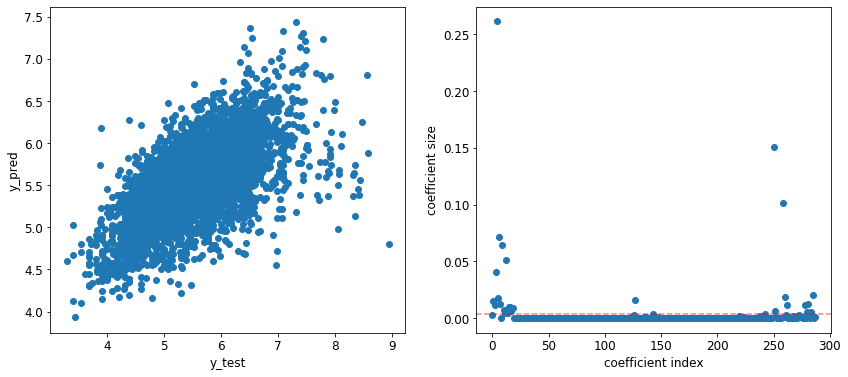

In [246]:
fig, axes = plt.subplots(1, 2, figsize = (14, 6))
axes = axes.flatten()

y_pred = grid.predict(X_test)
axes[0].scatter(y_test, y_pred)
axes[0].set_xlabel('y_test')
axes[0].set_ylabel('y_pred')

coef = grid.best_estimator_.named_steps['linear-regression'].feature_importances_
mean_coef = np.mean(coef)
axes[1].plot(coef, 'o')
axes[1].set_xlabel('coefficient index')
axes[1].set_ylabel('coefficient size')
axes[1].axhline(y = mean_coef, color = 'red', linestyle = '--', alpha = 0.5)
plt.show()

The mean coefficient size is 0, but there are a number of coefficients whose magnitude deviates from 0. 

In [281]:
listings_r = rm_outliers(listings)
Xr = listings_r.drop('price_total', axis = 1)
yr = np.log(listings_r['price_total']) # log price
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, random_state = 0)
grid.fit(Xr_train, yr_train)

KeyboardInterrupt: 

### Discussion

That the test score is barely at 0.60 is not encouraging. Since the testing $R^2$ score greater than the training $R^2$ score, the problem does not seem to be overfitting of the model but rather the lack of model fit overall. For further improvement of the model, we suggest two modifications. 

First, it seems that we need a more aggressive feature selection, for the number of features used by the best estimator model (namely, lasso regression with alpha 0.0001) is close to 300. This is about half of the features in `X_transformed` from which we obtained the train-test split. We cannot get the feature names, but it seems that the features with the largest coefficients are between index 100 to 400, which most likely refers to the categorical features that have been encoded into dummies by `categorical_transformer()`. 

Second, we should further investigate why the best estimator was not lasso regression with RANSAC as this estimator was specifically chosen to deal with potentially influential points. One possibility is that these points are not influential and therefore did not improve lasso regression from the baseline. The other possibility is that because RANSAC does not fit well when the outliers are [small fraction of the sample](https://scikit-learn.org/stable/modules/linear_model.html#ransac-regression), RANSAC was not the optimal method to deal with outliers in this case. Perhaps we should add alternative models such as Huber regression. 